# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I classify tweets as Neutral, Pro-vax or Anti-vax using two bidirectional stacked RNNs with LSTM/GRU cells.

## Install Dependencies

In [1]:
!pip install -U torch==1.8.0 torchtext==0.9.0

## Import Packages

In [2]:
%matplotlib inline
import io
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import re
import csv

import torch
import torch.nn as nn
from torchtext.legacy import data   
from torchtext.vocab import GloVe
from torchtext.legacy.data import BucketIterator
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, accuracy_score, mean_absolute_error

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Use GPU for faster processing

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Upload dataset - Create and Clean dataframe

In [4]:
upload_train = files.upload()

Saving vs_train.csv to vs_train (1).csv


In [5]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev (1).csv


In [6]:
train_df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
dev_df = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [7]:
# remove empty instances / duplicates
train_df.dropna(subset = ["tweet"], inplace=True)
train_df.drop_duplicates(subset = ["tweet"], inplace=True)

dev_df.dropna(subset = ["tweet"], inplace=True)

# drop column with indices
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True) 
dev_df.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [8]:
# remove special characters, urls, emojis and lowercase tweets
train_df["tweet"] = train_df["tweet"].apply(lambda line: re.sub('[^A-Za-z0-9]+', ' ', re.sub(r'http\S+', ' ',line.lower().strip())))
dev_df["tweet"] = dev_df["tweet"].apply(lambda line: re.sub('[^A-Za-z0-9]+', ' ', re.sub(r'http\S+', ' ',line.lower().strip())))

In [9]:
# remove empty instances again
train_df.dropna(subset = ["tweet"], inplace=True)
dev_df.dropna(subset = ["tweet"], inplace=True)

In [10]:
print(train_df) # training data

                                                   tweet  label
0      sip n shop come thru right now marjais popular...      0
1      i don t know about you but my family and i wil...      1
2       msignorile immunizations should be mandatory ...      2
3      president obama spoke in favor of vaccination ...      0
4       myfoxla arizona monitoring hundreds for measl...      0
...                                                  ...    ...
15971   salon if u believe the anti vax nutcases caus...      1
15972  how do you feel about parents who don t vaccin...      0
15973  70 preschoolers tested for measles in simi val...      0
15974  finance minister budget offers room to procure...      0
15975  are you up to date on vaccines take cdc s vacc...      2

[15881 rows x 2 columns]


In [11]:
print(dev_df) # validation data

                                                  tweet  label
0      user they had a massive surge in with covid d...      1
1     required vaccines for school parents and guard...      0
2      kcstar two more johnson county children have ...      0
3     nv can do better which states are the best and...      2
4     nothing like killing ourselves w our own fear ...      2
...                                                 ...    ...
2277  rt abc7 number of measles cases reported in ca...      0
2278  evidence points to the idea that measles affec...      0
2279  where s savedyouaclick voxdotcom why you shoul...      2
2280  some of my favorite people have autism if that...      2
2281  coronavirus the married couple behind the succ...      0

[2282 rows x 2 columns]


## Use Glove Embeddings

In [12]:
TEXT = data.Field(tokenize="spacy", batch_first=True)
LABEL = data.Field(sequential=False, use_vocab=False, is_target=True)

In [13]:
train_df.to_csv("train.csv", index=False)
dev_df.to_csv("valid.csv", index=False)

train_data, valid_data = data.TabularDataset.splits(
    path="", train="train.csv", 
    validation="valid.csv",format="csv", skip_header=True, 
    fields=[('tweet', TEXT), ('label', LABEL)]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 15881
Number of validation examples: 2282


In [14]:
# avoid words that dont offer any info
TEXT.build_vocab(train_data, valid_data, vectors='glove.twitter.27B.100d', max_size=20000, min_freq=5)

# get the vocab instance
vocab = TEXT.vocab
vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0952,  0.3702,  0.5429,  ..., -0.5108,  0.4688,  0.3488],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2163,  0.1924,  0.3433,  ...,  0.1079,  0.0727,  0.4788],
        [ 0.8071, -0.8602, -0.6612,  ..., -0.8826, -0.4987,  1.3513]])

In [15]:
TEXT.vocab.freqs.most_common(10) # seems right since we see many stopwords or medical terms

[('the', 9936),
 ('to', 7894),
 (' ', 6059),
 ('vaccine', 5815),
 ('a', 5787),
 ('measles', 5075),
 ('of', 4966),
 ('and', 4559),
 ('i', 4488),
 ('in', 4301)]

In [16]:
LABEL.build_vocab(train_data)
vocab_label = LABEL.vocab
print("Size of LABEL vocabulary:",len(vocab_label))
vocab_label.freqs

Size of LABEL vocabulary: 4


Counter({'0': 7385, '1': 2070, '2': 6426})

In [17]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 4893
Unique tokens in LABEL vocabulary: 4


## Create Batch Iterator

In [18]:
BATCH_SIZE = 32
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), sort_key=lambda x: len(x.tweet),
    batch_size=BATCH_SIZE, shuffle=True, device=device)

LABEL.vocab.freqs

Counter({'0': 7385, '1': 2070, '2': 6426})

In [19]:
pretrained_embeddings = TEXT.vocab.vectors.to(device)
pretrained_embeddings.shape

torch.Size([4893, 100])

In [20]:
pretrained_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0952,  0.3702,  0.5429,  ..., -0.5108,  0.4688,  0.3488],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2163,  0.1924,  0.3433,  ...,  0.1079,  0.0727,  0.4788],
        [ 0.8071, -0.8602, -0.6612,  ..., -0.8826, -0.4987,  1.3513]],
       device='cuda:0')

## Attention Layer

In [21]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, hidden_size)

    def forward(self, rnn_outputs, final_hidden_state):
        batch_size, seq_len, _ = rnn_outputs.shape
        attn_weights = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
        attn_weights = torch.bmm(attn_weights, final_hidden_state.unsqueeze(2)) # product
        attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
        context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
        attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1))) # attention vector is ready 
        return attn_hidden, attn_weights

## LSTM

In [22]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, embedding_size, output_size, weights, bidirectional, skip_connections, attention):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.bidirectional = bidirectional # bool   
        self.skip_connections = skip_connections # bool
        self.attn = attention # bool
        if (self.skip_connections):
          self.skip = nn.Identity()
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(input_size=self.embedding_size,
                           hidden_size=self.hidden_size,
                           #dropout=0.2,
                           num_layers=self.num_layers, 
                           bidirectional=self.bidirectional,
                           batch_first=True
                           )

        # self.rnns = nn.ModuleList()
        # for i in range(self.num_layers):
        #   if i == 0:
        #     self.rnns.append(nn.LSTM(self.embedding_size, self.hidden_size, 1))
        #   else:
        #     self.rnns.append(nn.LSTM(self.hidden_size, self.hidden_size, 1))
        
        #self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.2)

        if self.bidirectional: 
          self.fc = nn.Linear(self.hidden_size*2, self.output_size) # runs inputs from past to future and from future to past
          if (attention):
            self.attention = Attention(self.hidden_size * 2)
        else:
          self.fc = nn.Linear(hidden_size, self.output_size)
          if (attention):
            self.attention = Attention(self.hidden_size)

    def forward(self, x):
        x = self.embedding(x)

        if self.bidirectional:
            h = torch.zeros((self.num_layers*2, x.size(0), self.hidden_size)).to(device) # hidden state
            c = torch.zeros((self.num_layers*2, x.size(0), self.hidden_size)).to(device) # cell state
        else:
            h = torch.zeros((self.num_layers, x.size(0), self.hidden_size)).to(device)
            c = torch.zeros((self.num_layers, x.size(0), self.hidden_size)).to(device)

        out, hidden = self.lstm(x, (h, c))

        # LSTM Cells for skip connections
        # outputs = []
        # for i in range(self.num_layers):
        #     #if i != 0:
        #         #x = F.dropout(x, p=0.2, training=True)
        #     out, hidden = self.rnns[i](x)
        #     outputs.append(out)
        #     if (self.skip_connections and out.shape == x.shape):
        #       out = out + self.skip(x) 
        #     x = out
            

        final_hidden_state = None

        if self.bidirectional: 
          if (self.attn):
            final_state = hidden[0].view(self.num_layers, 2, x.size(0), self.hidden_size)[-1]
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1) # concatenate two hidden states
          else:
            out = out.contiguous().view(-1, self.hidden_size*2)  # results
        else:
          if (self.attn):
            final_state = hidden[0].view(self.num_layers, 1, x.size(0), self.hidden_size)[-1]
            final_hidden_state = final_state.squeeze(0)
          else:
            out = out.contiguous().view(-1, self.hidden_size)

        #out = self.tanh(out)
        #out = self.relu(out)
        #out = self.dropout(out)

        if (self.attn):
          out, attn_weights = self.attention(out, final_hidden_state)
        
        out = self.fc(out)  

        # batch first
        out = out.view(x.size(0), -1, self.output_size)
        # last batch
        out = out[:, -1, :]

        return out.to(device)

### Configurations

In [23]:
#Define layer sizes, parameters
vocab_size = pretrained_embeddings.shape[0]
hidden_size = 64
num_layers = 3
embedding_size = pretrained_embeddings.shape[1]
output_size = 3
bidirectional = True
skip_connections = False
attention = False

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, optimizer
model = LSTM(vocab_size, hidden_size, num_layers, embedding_size, output_size, pretrained_embeddings, bidirectional, skip_connections, attention).to(device)
model.embedding.weight.data = pretrained_embeddings
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)

clip = 2

In [24]:
model

LSTM(
  (embedding): Embedding(4893, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [25]:
epoch_loss = []
epoch_loss_dev = []
epoch_acc = []
epoch_acc_dev = []


for epoch in range(40):

  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0

  # sets the mode to train
  model.train()
  for (tweet, label) in train_iterator:  # for every batch
    if tweet.shape[0] == BATCH_SIZE:
      tweet = tweet.to(device)
      label = label.to(device)
      y_pred = model(tweet)
      loss = criterion(y_pred, label)
      batch_losses.append(loss)
      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      #Perform gradient clipping to address exploding gradients
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()

      # Total number of labels
      total += label.size(0)
      # Total correct predictions
      _,pred_label = torch.max(y_pred, dim = 1)
      batch_acc += (pred_label == label).sum()

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    # sets the mode to testing
    model.eval()
    for (tweet, label) in valid_iterator:
      if tweet.shape[0] == BATCH_SIZE:
        tweet = tweet.to(device)
        label = label.to(device)
        y_dev_pred = model(tweet)
        loss_dev = criterion(y_dev_pred, label)
        batch_losses_dev.append(loss_dev)
        # number of labels
        total_dev += label.size(0)
        # correct predictions
        _,pred_label = torch.max(y_dev_pred, dim = 1)  # get max probability
        #print(y_dev_pred, pred_label)
        batch_acc_dev += (pred_label == label).sum()


  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_iterator)
  valid_loss = sum(batch_losses_dev)/len(valid_iterator)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)
  epoch_acc.append(accuracy)
  epoch_acc_dev.append(accuracy_dev)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 0.98952 | Train Accuracy = 0.47083 | Validation Loss = 1.04791 | Validation Accuracy = 0.43926 
Epoch   1: | Train Loss = 0.93829 | Train Accuracy = 0.52671 | Validation Loss = 0.96180 | Validation Accuracy = 0.47667 
Epoch   2: | Train Loss = 0.82661 | Train Accuracy = 0.62802 | Validation Loss = 0.89488 | Validation Accuracy = 0.61972 
Epoch   3: | Train Loss = 0.78942 | Train Accuracy = 0.65341 | Validation Loss = 0.87822 | Validation Accuracy = 0.62060 
Epoch   4: | Train Loss = 0.77126 | Train Accuracy = 0.66545 | Validation Loss = 0.88320 | Validation Accuracy = 0.58627 
Epoch   5: | Train Loss = 0.76192 | Train Accuracy = 0.66866 | Validation Loss = 0.82750 | Validation Accuracy = 0.62456 
Epoch   6: | Train Loss = 0.75253 | Train Accuracy = 0.67534 | Validation Loss = 0.81868 | Validation Accuracy = 0.62764 
Epoch   7: | Train Loss = 0.74529 | Train Accuracy = 0.67780 | Validation Loss = 0.81955 | Validation Accuracy = 0.61136 
Epoch   8: | Train Loss 

### Evaluation

In [26]:
valid = pd.read_csv("valid.csv")

In [27]:
# Get predictions
def predict(sentence):
    tokenized = [tok for tok in sentence.split()]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]

    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(0)
    prediction = model(tensor.to(device))

    preds, ind = torch.max(F.softmax(prediction, dim=-1), 1)

    return preds, ind, F.softmax(prediction, dim=-1)

In [28]:
pred_proba = []
pred = []
for k in valid.tweet:
  temp = predict(k)
  pred.append(temp[1].cpu().numpy())
  pred_proba.append(temp[2].cpu().detach().numpy())
  
# Compare predictions to actual labels
print(classification_report(valid.label, pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1065
           1       0.56      0.45      0.50       296
           2       0.68      0.68      0.68       921

    accuracy                           0.71      2282
   macro avg       0.67      0.64      0.65      2282
weighted avg       0.70      0.71      0.70      2282



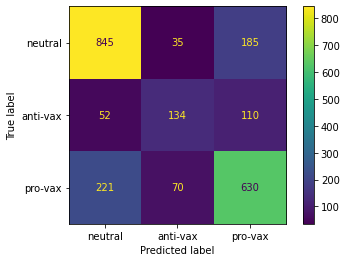

In [29]:
target_names = ['neutral', 'anti-vax', 'pro-vax']

cm = confusion_matrix(valid.label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [30]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(valid.label, pred, average='micro'))

Precision-Recall-F1 - Training Data :
(0.7050832602979842, 0.7050832602979842, 0.7050832602979842, None)


In [31]:
proba_list = []
for i in pred_proba:
  proba_list.append(i.squeeze(0).tolist())
#proba_list

In [32]:
macro_roc_auc_ovo = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print()
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.827906 (macro),
0.832405 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.836991 (macro),
0.837574 (weighted by prevalence)


### Plots

In [33]:
# probabilities
df_prob = pd.DataFrame(proba_list)
df_prob

,0,1,2
0,0.152111,0.705194,0.142695
1,0.377450,0.086261,0.536289
2,0.817987,0.016188,0.165825
3,0.494090,0.018945,0.486965
4,0.193482,0.043674,0.762844
...,...,...,...
2277,0.982069,0.003405,0.014526
2278,0.541877,0.270966,0.187158
2279,0.246266,0.046165,0.707569
2280,0.081102,0.072154,0.846744


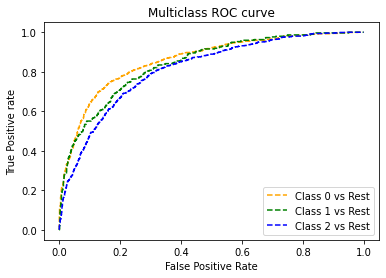

In [34]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(valid.label, df_prob[i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

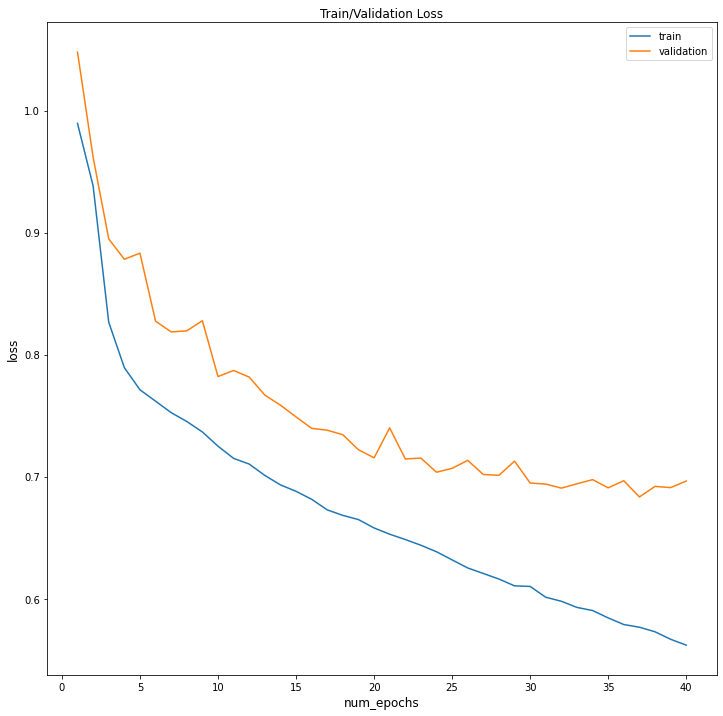

In [35]:
def plot_graph_loss(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_loss(40)

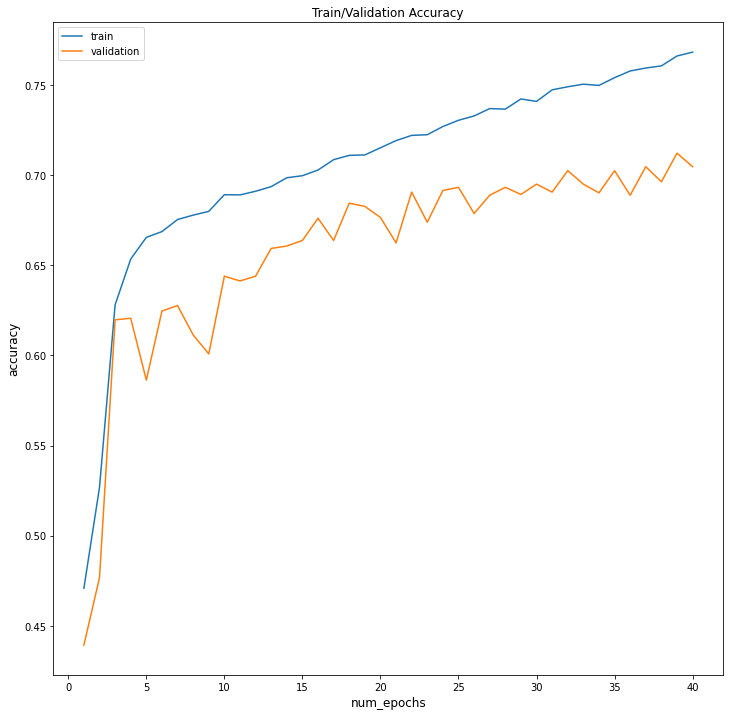

In [36]:
def plot_graph_acc(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , epoch_acc, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_acc_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_acc(40)    

## GRU

In [37]:
class GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, embedding_size, output_size, weights, bidirectional, skip_connections, attention):
        super(GRU, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.bidirectional = bidirectional

        self.skip_connections = skip_connections
        if (self.skip_connections):
          self.skip = nn.Identity()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.GRU = nn.GRU(input_size=self.embedding_size,
                           hidden_size=self.hidden_size,
                           #dropout=0.2,
                           num_layers=self.num_layers, 
                           bidirectional=self.bidirectional,
                           batch_first=True
                           )

        # self.rnns = nn.ModuleList()
        # for i in range(self.num_layers):
        #   if i == 0:
        #     self.rnns.append(nn.GRU(self.embedding_size, self.hidden_size, 1))
        #   else:
        #     self.rnns.append(nn.GRU(self.hidden_size, self.hidden_size, 1))

        
        if self.bidirectional: 
          self.fc = nn.Linear(self.hidden_size*2, self.output_size)
          if (attention):
            self.attention = Attention(self.hidden_size * 2)
        else:
          self.fc = nn.Linear(self.hidden_size, self.output_size)
          if (attention):
            self.attention = Attention(self.hidden_size)

        self.attn = attention
        #self.dropout = nn.Dropout(0.2)
        #self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.embedding(x)
        if self.bidirectional:
            h = torch.zeros((self.num_layers*2, x.size(0), self.hidden_size)).to(device)
        else:
            h = torch.zeros((self.num_layers, x.size(0), self.hidden_size)).to(device)

        out, hidden = self.GRU(x, h)

        # GRU Cells for skip connections
        # outputs = []
        # for i in range(self.num_layers):
        #     #if i != 0:
        #         #x = F.dropout(x, p=0.2, training=True)
        #     out, hidden = self.rnns[i](x)
        #     outputs.append(out)
        #     if (self.skip_connections and out.shape == x.shape):
        #       out = out + self.skip(x) 
        #     x = out

        final_hidden_state = None

        if self.bidirectional: 
          if (self.attn):
            final_state = hidden.view(self.num_layers, 2, x.size(0), self.hidden_size)[-1]
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1) 
          else:
            out = out.contiguous().view(-1, self.hidden_size*2)
        else:
          if (self.attn):
            final_state = hidden.view(self.num_layers, 1, x.size(0), self.hidden_size)[-1]
            final_hidden_state = final_state.squeeze(0)
          else:
            out = out.contiguous().view(-1, self.hidden_size)

        #out = self.dropout(out)
        #out = self.tanh(out)
        #out = self.relu(out)
        if (self.attn):
          out, attn_weights = self.attention(out, final_hidden_state)
        
        out = self.fc(out)   
         
        out = out.view(x.size(0), -1, self.output_size)
        out = out[:, -1, :]
        
        return out.to(device)

### Configurations

In [38]:
#Define layer sizes, parameters
vocab_size = pretrained_embeddings.shape[0]
hidden_size = 128
num_layers = 3
embedding_size = pretrained_embeddings.shape[1]
output_size = 3
bidirectional = True
skip_connections = False
attention = False

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, optimizer
model = GRU(vocab_size, hidden_size, num_layers, embedding_size, output_size, pretrained_embeddings, bidirectional, skip_connections, attention).to(device)
model.embedding.weight.data = pretrained_embeddings
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

clip = 2

In [39]:
model

GRU(
  (embedding): Embedding(4893, 100)
  (GRU): GRU(100, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [40]:
epoch_loss = []
epoch_loss_dev = []
epoch_acc = []
epoch_acc_dev = []


for epoch in range(40):

  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0

  # training
  model.train()
  for (tweet, label) in train_iterator:  # for every batch
    if tweet.shape[0] == BATCH_SIZE:
      tweet = tweet.to(device)
      label = label.to(device)
      y_pred = model(tweet)
      loss = criterion(y_pred, label)
      batch_losses.append(loss)
      #Delete previously stored gradients
      optimizer.zero_grad()
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()

      # Total number of labels
      total += label.size(0)
      # Total correct predictions
      _,pred_label = torch.max(y_pred, dim = 1)
      batch_acc += (pred_label == label).sum()

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    model.eval()
    for (tweet, label) in valid_iterator:
      if tweet.shape[0] == BATCH_SIZE:
        tweet = tweet.to(device)
        label = label.to(device)
        y_dev_pred = model(tweet)
        loss_dev = criterion(y_dev_pred, label)
        batch_losses_dev.append(loss_dev)
        # number of labels
        total_dev += label.size(0)
        # correct predictions
        _,pred_label = torch.max(y_dev_pred, dim = 1)  # get max probability
        batch_acc_dev += (pred_label == label).sum()


  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_iterator)
  valid_loss = sum(batch_losses_dev)/len(valid_iterator)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)
  epoch_acc.append(accuracy)
  epoch_acc_dev.append(accuracy_dev)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 0.98173 | Train Accuracy = 0.47222 | Validation Loss = 1.01315 | Validation Accuracy = 0.43178 
Epoch   1: | Train Loss = 0.87981 | Train Accuracy = 0.57535 | Validation Loss = 0.84994 | Validation Accuracy = 0.62808 
Epoch   2: | Train Loss = 0.77517 | Train Accuracy = 0.65801 | Validation Loss = 0.82456 | Validation Accuracy = 0.59683 
Epoch   3: | Train Loss = 0.75484 | Train Accuracy = 0.66973 | Validation Loss = 0.79046 | Validation Accuracy = 0.66241 
Epoch   4: | Train Loss = 0.73590 | Train Accuracy = 0.67704 | Validation Loss = 0.79195 | Validation Accuracy = 0.64525 
Epoch   5: | Train Loss = 0.71711 | Train Accuracy = 0.68353 | Validation Loss = 0.77054 | Validation Accuracy = 0.66021 
Epoch   6: | Train Loss = 0.70139 | Train Accuracy = 0.69008 | Validation Loss = 0.74688 | Validation Accuracy = 0.67254 
Epoch   7: | Train Loss = 0.68729 | Train Accuracy = 0.69802 | Validation Loss = 0.74230 | Validation Accuracy = 0.67782 
Epoch   8: | Train Loss 

In [41]:
valid = pd.read_csv("valid.csv")

In [42]:
def predict(sentence):
    tokenized = [tok for tok in sentence.split()]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]

    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(0)
    prediction = model(tensor.to(device))

    preds, ind = torch.max(F.softmax(prediction, dim=-1), 1)
    return preds, ind, F.softmax(prediction, dim=-1)


In [43]:
pred_proba = []
pred = []
for k in valid.tweet:
  temp = predict(k)
  pred.append(temp[1].cpu().numpy())
  pred_proba.append(temp[2].cpu().detach().numpy())
  
# Compare predictions to actual labels
print(classification_report(valid.label, pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1065
           1       0.48      0.43      0.45       296
           2       0.69      0.67      0.68       921

    accuracy                           0.70      2282
   macro avg       0.64      0.63      0.63      2282
weighted avg       0.69      0.70      0.69      2282



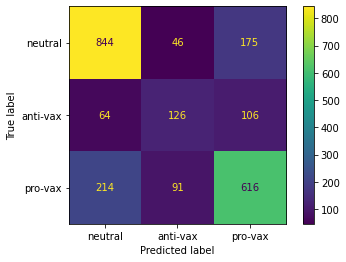

In [44]:
target_names = ['neutral', 'anti-vax', 'pro-vax']

cm = confusion_matrix(valid.label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [45]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(valid.label, pred, average='micro'))

Precision-Recall-F1 - Training Data :
(0.6950043821209465, 0.6950043821209465, 0.6950043821209465, None)


In [46]:
proba_list = []
for i in pred_proba:
  proba_list.append(i.squeeze(0).tolist())
#proba_list

In [47]:
macro_roc_auc_ovo = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(valid.label.tolist(), proba_list, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print()
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.802266 (macro),
0.809256 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.813007 (macro),
0.821714 (weighted by prevalence)


### Plots

In [48]:
# probabilities
df_prob = pd.DataFrame(proba_list)
df_prob

,0,1,2
0,0.695779,0.157493,0.146728
1,0.675035,0.056557,0.268408
2,0.679936,0.163700,0.156365
3,0.327079,0.269561,0.403360
4,0.021811,0.023256,0.954933
...,...,...,...
2277,0.977712,0.006610,0.015678
2278,0.824667,0.096298,0.079036
2279,0.166252,0.063931,0.769817
2280,0.012646,0.022916,0.964437


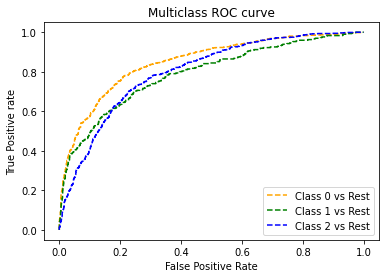

In [49]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(valid.label, df_prob[i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

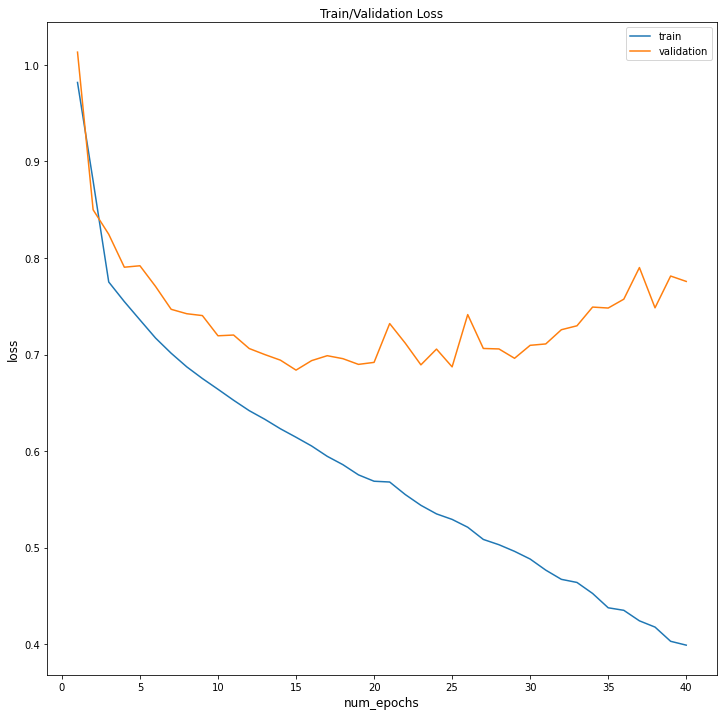

In [50]:
def plot_graph_loss(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_loss(40)

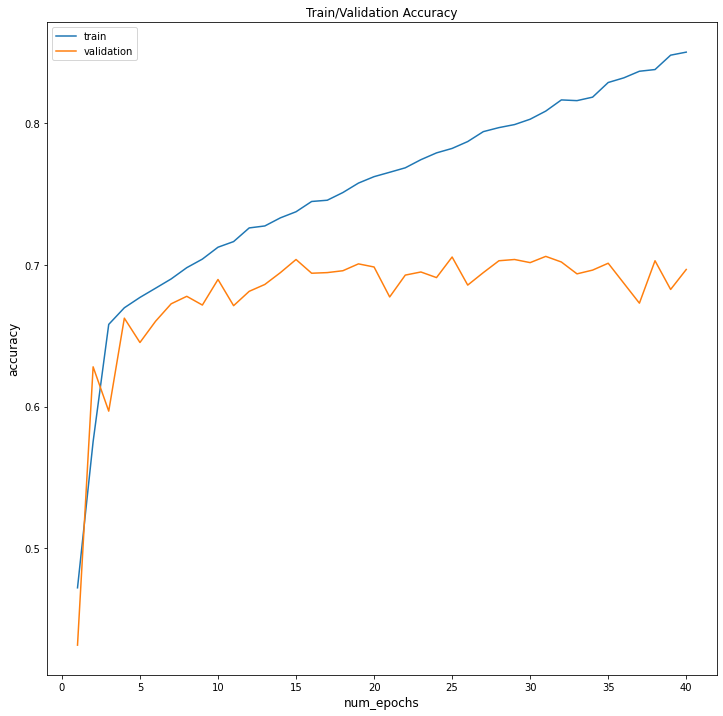

In [51]:
def plot_graph_acc(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , epoch_acc, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_acc_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_acc(40)    